# PaddlePaddle Fluid - ResNet 图像分类

Jupyter Notebook
* http://jupyter.org/

PaddlePaddle
* [PaddlePaddle 图像分类模型库](https://github.com/PaddlePaddle/models/tree/develop/fluid/PaddleCV/image_classification)
* [PaddlePaddle 官方文档](http://www.paddlepaddle.org/documentation/docs/zh/1.1/beginners_guide/index.html)

常用库
* [Numpy 矩阵库](http://www.numpy.org/)
* [Pillow 图像库](https://pillow.readthedocs.io/)

ResNet 论文
* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
* [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)

批正则化 (Batch-Normalization) 论文
* [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

ImageNet 数据集论文和下载链接
* [ImageNet: A large-scale hierarchical image database](http://www.image-net.org/papers/imagenet_cvpr09.pdf)
* 数据集下载 (需要官网注册，需要160G左右硬盘空间):
  * [官网](http://www.image-net.org/)
  * [PaddlePaddle 脚本下载](https://github.com/PaddlePaddle/models/tree/develop/fluid/PaddleCV/image_classification#data-preparation)
  
Natural Images 数据集论文和下载链接
* [Effects of Degradations on Deep Neural Network Architectures](https://arxiv.org/abs/1807.10108)
* [Kaggle 下载链接](https://www.kaggle.com/prasunroy/natural-images)

## ResNet-50 整体结构 以及 其优势

### 整体结构图

参数含义：
* K 代表 Kernel，是卷积核的大小 或者 池化层池化核的大小
* F 代表 Filter，是卷积操作输出的特征通道数目
* S 代表 Stride，是卷积核的步幅 (两次卷积之间跳过的像素的数目)

<img src="notebook/ResNet-Page-3.png" alt="ResNet Architecture" style="width: 35%;"/>

### Bottleneck 模块结构图 (Stride = 2)

注意点：
* Bottleneck 的参数 F 代表的是传入的 Filter 大小，实际上整个模块输出的特征通道是 $4 \cdot F$

<img src="notebook/ResNet-Page-1.png" alt="ResNet Bottleneck Block S=2" style="width: 80%;"/>

### Bottleneck 模块结构图 (Stride = 1)

注意点：
* Bottleneck 的参数 F 代表的是传入的 Filter 大小，实际上整个模块输出的特征通道是 $4 \cdot F$

<img src="notebook/ResNet-Page-2.png" alt="ResNet Bottleneck Block S=1" style="width: 60%;"/>

In [1]:
import os
import math
import random

import paddle
import paddle.fluid as fluid

import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
# 设置随机数种子
random.seed(42)
np.random.seed(42)

# 设置训练和预测时的批大小
batch_size = 16

# 预训练数据集 ImageNet 所有图像的均值与方差，用于输入图像标准化
mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

# 正则化一张图片
def normalize_image(image):
    image = (image - mean) / std
    return image

# 逆向正则化一张图片
def denorm_image(image):
    return image * std + mean

<img src="notebook/image-normalize.jpg" alt="Image Normalize" style="width: 80%;"/>

In [25]:
# 解压好的 Natural Images 路径
#files_path = 'F:/paddle_cognization/NaturalImages/natural-images'
files_path = './natural-images/natural_images'

# Natural Images 8 个分类 - 对应 8 个文件夹
label_names = ["airplane", "car", "cat", "dog", "flower", "fruit", "motorbike", "person"]
label_class = {name: index for index, name in enumerate(label_names)}

file: ./natural-images/natural_images\airplane\airplane_0000.jpg


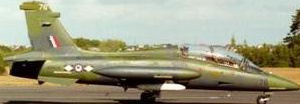

file: ./natural-images/natural_images\car\car_0000.jpg


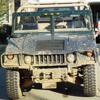

file: ./natural-images/natural_images\cat\cat_0000.jpg


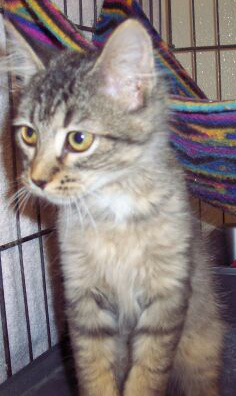

file: ./natural-images/natural_images\dog\dog_0000.jpg


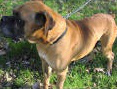

file: ./natural-images/natural_images\flower\flower_0000.jpg


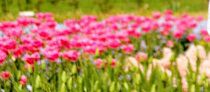

file: ./natural-images/natural_images\fruit\fruit_0000.jpg


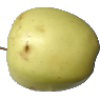

file: ./natural-images/natural_images\motorbike\motorbike_0000.jpg


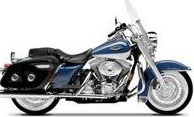

file: ./natural-images/natural_images\person\person_0000.jpg


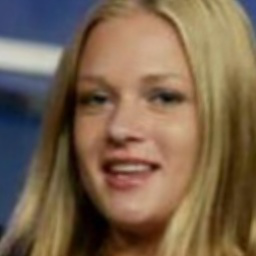

In [26]:
# 让我们看一下 Natural Images 图像的样子吧
for name in label_names:
    path = os.path.join(files_path, name, '%s_0000.jpg' % name)
    print('file:', path)
    image = PIL.Image.open(path)
    display(image)

## 预训练模型

为什么我们要预训练模型？
* 训练时间
* 数据集大小

In [27]:
# 下载 PaddlePaddle ResNet-50 预训练模型参数，并解压于当前文件夹相同目录
# http://paddle-imagenet-models.bj.bcebos.com/resnet_50_model.tar
#列出当前jupyter工作目录
cwd = os.getcwd()
print(cwd)
pretrained_model_path = './resnet_50_model/resnet_50/115'

# 从预训练模型参数列表获取 ResNet-50 中所有持久参数列表
params_list = os.listdir(pretrained_model_path)
#print(params_list )

F:\何文轩（大学）\毕业设计-青铜器铭文识别\paddle_cognization\PaddlePaddle-ResNet-ImageClassification-master


In [6]:
# 列出所有数据集里的图片，给出 (路径, 类名) 的列表
# - 训练时，使用每个分类里前 80%
# - 验证时，使用每个分类里后 20%
def list_files(basepath, mode='all'):
    assert mode in ['train', 'test', 'all']
    
    files = []
    for name in label_names:
        class_files = sorted(os.listdir(os.path.join(basepath, name)))
        
        part = int(len(class_files) * 0.8)
        if mode == 'train':
            class_files = class_files[:part]
        elif mode == 'test':
            class_files = class_files[part:]
        
        for file in class_files:
            files.append((os.path.join(basepath, name, file), name))
    return files

## PaddlePaddle Reader

[官方文档](http://www.paddlepaddle.org/documentation/docs/zh/1.1/user_guides/howto/prepare_data/reader.html)

官方文档中有很多数据读取的方式
然而在现实生活中，往往数据来源丰富，无论从图片、消息队列、非关系型数据库，还是解析自定义格式的二进制Blob、HTTP Request等，都是繁杂难以处理的，这里比较推荐使用 py_reader 接口来封装 Python 数据获取到 PaddlePaddle 后端 (C++) 图执行的数据生命周期，这样方便使用并且可以使用 PaddlePaddle 提供的 batch, prefetch 等操作提升整体数据流的性能

In [7]:
class BaseReader(object):
    """定义 PaddlePaddle 的 Reader 的生成类
    
    由它提供生成 train_reader 和 test_reader 两种类型的 Reader
    使用两种类型的 reader 的原因是因为 train 和 test 在图像预处理 (图像增强) 的部分使用的操作不相同
    
    在训练的过程中，尽可能希望模型能够看到更多更丰富更多样化的输入数据，所以经常会使用类似于
    * 随机切块
    * 随机翻转
    * 随机调整图像明度、色彩
    等等操作。
    
    而预测/验证的情况下，尽可能要保证图像原本完整的信息，可能会使用的有
    * 图像拉伸
    * 图像中心切块
    等等尽量能够保留最多最显著图像内容部分的操作。
    """
    @staticmethod
    def rescale_image(img, target_size):
        width, height = img.size
        percent = float(target_size) / min(width, height)
        resized_width = int(round(width * percent))
        resized_height = int(round(height * percent))
        img = img.resize((resized_width, resized_height), PIL.Image.LANCZOS)
        return img
    
    @staticmethod
    def resize_image(img, target_size):
        img = img.resize((target_size, target_size), PIL.Image.LANCZOS)
        return img

    @staticmethod
    def crop_image(img, target_size, center=True):
        width, height = img.size
        size = target_size
        if center == True:
            w_start = (width - size) / 2
            h_start = (height - size) / 2
        else:
            w_start = np.random.randint(0, width - size + 1)
            h_start = np.random.randint(0, height - size + 1)
        w_end = w_start + size
        h_end = h_start + size
        img = img.crop((w_start, h_start, w_end, h_end))
        return img
    
    @staticmethod
    def random_crop(img, size, scale=[0.08, 1.0], ratio=[3. / 4., 4. / 3.]):
        aspect_ratio = math.sqrt(np.random.uniform(*ratio))
        w = 1. * aspect_ratio
        h = 1. / aspect_ratio

        bound = min((float(img.size[0]) / img.size[1]) / (w**2),
                    (float(img.size[1]) / img.size[0]) / (h**2))
        scale_max = min(scale[1], bound)
        scale_min = min(scale[0], bound)

        target_area = img.size[0] * img.size[1] * np.random.uniform(scale_min, scale_max)
        target_size = math.sqrt(target_area)
        w = int(target_size * w)
        h = int(target_size * h)

        i = np.random.randint(0, img.size[0] - w + 1)
        j = np.random.randint(0, img.size[1] - h + 1)

        img = img.crop((i, j, i + w, j + h))
        img = img.resize((size, size), PIL.Image.LANCZOS)
        return img
    
    @staticmethod
    def random_flip(img):
        if np.random.randint(0, 2) == 1:
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        return img

    @staticmethod
    def rotate_image(img):
        angle = np.random.randint(-10, 11)
        img = img.rotate(angle)
        return img
    
    def create_train_reader(self, files):
        def _reader():
            for file, labelname in files:
                image = PIL.Image.open(file)
                
                image = BaseReader.rotate_image(image)
                image = BaseReader.random_crop(image, 224)
                image = BaseReader.random_flip(image)
                
                image = np.array(image).astype('float32').transpose((2, 0, 1)) / 255
                image = normalize_image(image)
                
                label = label_class[labelname]
                yield image, label
        return _reader

    def create_test_reader(self, files):
        def _reader():
            for file, labelname in files:
                image = PIL.Image.open(file)
                
                image = BaseReader.resize_image(image, 224)
                image = BaseReader.crop_image(image, 224)
                
                image = np.array(image).astype('float32').transpose((2, 0, 1)) / 255
                image = normalize_image(image)
                
                label = label_class[labelname]
                yield image, label
        return _reader


In [8]:
def image_grid(images, padding=3, pad_value=0):
    """从一批图像生成一张图像
    images   : 要求是 np.ndarray 符合 (batch, width, height, channel)
    padding  : 是两张图像之间的间隔像素
    pad_value: 是间隔像素的颜色
    """
    batch_size = images.shape[0]
    nrows, ncols, ncnls = images.shape[1:]

    impcol = math.ceil(math.sqrt(batch_size))
    improw = math.ceil(batch_size / impcol)

    ret_rows = improw * nrows + padding * (improw + 1)
    ret_cols = impcol * ncols + padding * (impcol + 1)

    ret = np.ones((ret_rows, ret_cols, ncnls)) * pad_value

    for ridx in range(improw):
        for cidx in range(impcol):
            idx = ridx * impcol + cidx
            if idx >= batch_size:
                break
            img = images[idx]
            rlb = (padding + nrows) * ridx + padding
            rub = (padding + nrows) * (ridx + 1)
            clb = (padding + ncols) * cidx + padding
            cub = (padding + ncols) * (cidx + 1)
            ret[rlb:rub, clb:cub, :] = img

    return ret

def display_image(image):
    """显示一张图像
    image 是 np.ndarray，符合 (batch, width, height, channel)
          归一化到 [0, 1]
    """
    image = (image * 255).astype(np.uint8)
    image = PIL.Image.fromarray(image)
    display(image)
    
def display_batch(images):
    """显示一批图像
    image 是 np.ndarray，符合 (batch, channel, width, height)
    """
    images = np.array([denorm_image(image) for image in images])
    images = images.transpose(0, 2, 3, 1)
    images = image_grid(images)
    display_image(images)

## ResNet 模型代码

大部分使用了 PaddlePaddle 模型库官方实现 [ResNet](https://github.com/PaddlePaddle/models/blob/58e9bc20305ea453d50eb924bc94a5f702109888/fluid/PaddleCV/image_classification/models/resnet.py)

修改了部分以进行 fine-tune
* batch_norm 和 fc 本身接受参数 is_test，传入以在不用 clone() 情形下正确处理 train, test 两种情况
* 展开了 bottleneck block 部分的代码，方便冻结前面的层，只 再训练 (finetune) 最后一个 block 以及 全连接层
* 去除了最后的 softmax 以保留 softmax 之前的结果

In [9]:
class ResNet():
    def __init__(self, is_test=False):
        self.is_test = is_test

    def net(self, input, class_dim=1000):
        # if layers == 50:
        #     depth = [3, 4, 6, 3]
        # elif layers == 101:
        #     depth = [3, 4, 23, 3]
        # elif layers == 152:
        #     depth = [3, 8, 36, 3]
        # num_filters = [64, 128, 256, 512]

        conv = self.conv_bn_layer(
            input=input, num_filters=64, filter_size=7, stride=2, act='relu', trainable=False)
        conv = fluid.layers.pool2d(
            input=conv, pool_size=3, pool_stride=2, pool_padding=1, pool_type='max')

        # 原本官方代码，这里我们针对 ResNet-50 进行展开，看起来更清晰
        # for block in range(len(depth)):
        #     for i in range(depth[block]):
        #         conv = self.bottleneck_block(
        #             input=conv,
        #             num_filters=num_filters[block],
        #             stride=2 if i == 0 and block != 0 else 1)

        conv = self.bottleneck_block(input=conv, num_filters=64, stride=1, trainable=False)
        conv = self.bottleneck_block(input=conv, num_filters=64, stride=1, trainable=False)
        conv = self.bottleneck_block(input=conv, num_filters=64, stride=1, trainable=False)

        conv = self.bottleneck_block(input=conv, num_filters=128, stride=2, trainable=False)
        conv = self.bottleneck_block(input=conv, num_filters=128, stride=1, trainable=False)
        conv = self.bottleneck_block(input=conv, num_filters=128, stride=1, trainable=False)
        conv = self.bottleneck_block(input=conv, num_filters=128, stride=1, trainable=False)

        conv = self.bottleneck_block(input=conv, num_filters=256, stride=2, trainable=False)
        for _ in range(5):
            conv = self.bottleneck_block(input=conv, num_filters=256, stride=1, trainable=False)

        conv = self.bottleneck_block(input=conv, num_filters=512, stride=2, trainable=False)
        conv = self.bottleneck_block(input=conv, num_filters=512, stride=1, trainable=False)
        conv = self.bottleneck_block(input=conv, num_filters=512, stride=1, trainable=True)

        pool = fluid.layers.pool2d(input=conv, pool_size=7, pool_type='avg', global_pooling=True)

        # 设置 全连接层 参数初始化，并且一定为 trainable
        stdv = 1.0 / math.sqrt(pool.shape[1] * 1.0)
        fc_param_attr = fluid.param_attr.ParamAttr(
            initializer=fluid.initializer.Uniform(-stdv, stdv), trainable=True)
        out = fluid.layers.fc(
            input=pool, size=class_dim, act=None, is_test=self.is_test, param_attr=fc_param_attr)

        return out

    def conv_bn_layer(self,
                      input,
                      num_filters,
                      filter_size,
                      stride=1,
                      groups=1,
                      act=None,
                      trainable=True):
        param_attr = fluid.ParamAttr(trainable=trainable)

        conv = fluid.layers.conv2d(
            input=input,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            act=None,
            bias_attr=False,
            param_attr=param_attr)
        return fluid.layers.batch_norm(
            input=conv, act=act, is_test=self.is_test, param_attr=param_attr)

    def shortcut(self, input, ch_out, stride, trainable=True):
        ch_in = input.shape[1]
        if ch_in != ch_out or stride != 1:
            return self.conv_bn_layer(input, ch_out, 1, stride=stride, trainable=trainable)
        else:
            return input

    def bottleneck_block(self, input, num_filters, stride, trainable=True):
        conv0 = self.conv_bn_layer(
            input=input,
            num_filters=num_filters,
            filter_size=1,
            stride=1,
            act='relu',
            trainable=trainable)
        conv1 = self.conv_bn_layer(
            input=conv0,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu',
            trainable=trainable)
        conv2 = self.conv_bn_layer(
            input=conv1,
            num_filters=num_filters * 4,
            filter_size=1,
            stride=1,
            act=None,
            trainable=trainable)

        short = self.shortcut(input, num_filters * 4, stride, trainable=trainable)

        return fluid.layers.elementwise_add(x=short, y=conv2, act='relu')


In [33]:
def create_network(image, label, class_dim=1000, is_test=False):
    # image 以及 label 是 Variable 类型，在再训练过程中，他们是在 py_reader 的数据流中产生的
    # 其类型和大小如下：
    #   image = fluid.layers.data(name='image', shape=(-1, 3, 224, 224), dtype='float32')
    #   label = fluid.layers.data(name='label', shape=(-1, 1), dtype='int64')
    
    # is_test 是表明现在是在创建训练还是验证模型
    # 由于是两个 fluid.Program 上下文，故建议分别创建
    
    model = ResNet(is_test=is_test)
    out = model.net(image, class_dim=class_dim)
    
    confidence = fluid.layers.softmax(out)
    top5_scores, top5_indices = fluid.layers.topk(confidence, k=5)
    
    loss = fluid.layers.cross_entropy(input=confidence, label=label)
    loss = fluid.layers.mean(x=loss)
    
    acc_top1 = fluid.layers.accuracy(input=out, label=label, k=1)
    acc_top5 = fluid.layers.accuracy(input=out, label=label, k=5)
    
    fetch_list = [
        image.name, label.name,
        out.name, confidence.name, top5_scores.name, top5_indices.name,
        loss.name, acc_top1.name, acc_top5.name
    ] 
    return loss, fetch_list

In [34]:
# 取得文件列表
train_files = list_files(files_path, mode='train')
test_files = list_files(files_path, mode='test')

np.random.shuffle(train_files)
np.random.shuffle(test_files)

# 预览一下他们 :)
print('训练文件列表:')
for i in range(batch_size):
    print(train_files[i])
print('验证文件列表:')
for i in range(batch_size):
    print(test_files[i])

训练文件列表:
('./natural-images/natural_images\\car\\car_0313.jpg', 'car')
('./natural-images/natural_images\\motorbike\\motorbike_0601.jpg', 'motorbike')
('./natural-images/natural_images\\fruit\\fruit_0186.jpg', 'fruit')
('./natural-images/natural_images\\dog\\dog_0328.jpg', 'dog')
('./natural-images/natural_images\\dog\\dog_0435.jpg', 'dog')
('./natural-images/natural_images\\cat\\cat_0702.jpg', 'cat')
('./natural-images/natural_images\\cat\\cat_0346.jpg', 'cat')
('./natural-images/natural_images\\fruit\\fruit_0058.jpg', 'fruit')
('./natural-images/natural_images\\motorbike\\motorbike_0001.jpg', 'motorbike')
('./natural-images/natural_images\\fruit\\fruit_0691.jpg', 'fruit')
('./natural-images/natural_images\\dog\\dog_0526.jpg', 'dog')
('./natural-images/natural_images\\flower\\flower_0235.jpg', 'flower')
('./natural-images/natural_images\\airplane\\airplane_0262.jpg', 'airplane')
('./natural-images/natural_images\\cat\\cat_0635.jpg', 'cat')
('./natural-images/natural_images\\cat\\cat_04

In [35]:
base_reader = BaseReader()

# 先来看看在 PaddlePaddle 里面这个 reader 怎么用，我们以验证数据作为例子
base_test_reader = base_reader.create_test_reader(test_files)

for data in base_test_reader():
    print('image-shape:', data[0].shape)
    print('label:', data[1])
    break
print()

base_test_reader = paddle.batch(base_test_reader, batch_size=batch_size)

for data in base_test_reader():
    print('data-type:', type(data))
    print('data-length:', len(data))
    print('image-shape:', data[0][0].shape)
    print('label:', data[0][1])
    break
print()
    
# 使用 numpy 将列表变成批数据的方法如下：
# 使用 np.stack(列表)

# 这里先将列表中的 image 部分取出变成一个列表，然后再 stack
images = [data[i][0] for i in range(batch_size)]
images = np.stack(images).astype(np.float32)
print('images-shape:', images.shape)
print('images-type:', images.dtype)

# label 部分同理
labels = [data[i][1] for i in range(batch_size)]
labels = np.stack(labels).reshape((batch_size, 1)).astype(np.int64)
print('labels-shape:', labels.shape)
print('labels-type:', labels.dtype)
print('labels:')
print(labels)

image-shape: (3, 224, 224)
label: 5

data-type: <class 'list'>
data-length: 16
image-shape: (3, 224, 224)
label: 5

images-shape: (16, 3, 224, 224)
images-type: float32
labels-shape: (16, 1)
labels-type: int64
labels:
[[5]
 [2]
 [2]
 [1]
 [4]
 [5]
 [0]
 [0]
 [1]
 [4]
 [5]
 [0]
 [4]
 [1]
 [7]
 [1]]


In [13]:
def log_topk_info(label, topk_scores, topk_indices):
    batch_size = topk_scores.shape[0]
    
    if label is not None:
        # label 大小 (batch, 1) -> (batch, ) 方便操作
        label = label.flatten()
    
    for bidx in range(batch_size):
        if label is not None:
            true_idx = label[bidx]
            print('label: %03d, ' % true_idx, end='')
        else:
            print('label: ---, ', end='')

        for kidx in range(5):
            topk_score = topk_scores[bidx, kidx]
            topk_index = topk_indices[bidx, kidx]
            print('%03d(%6.2f%%) ' % (topk_index, topk_score * 100), end='')
        print()

In [36]:
# 先来尝试一下完全使用 ImageNet 预训练的权重，效果怎样吧

test_program = fluid.Program()
test_startup = fluid.Program()

with fluid.program_guard(test_program, test_startup):
    with fluid.unique_name.guard():
        image = fluid.layers.data(name='image', shape=(-1, 3, 224, 224), dtype='float32')
        label = fluid.layers.data(name='label', shape=(-1, 1), dtype='int64')
        _,fetch_list = create_network(image, label, is_test=True)

# 大家如果没有 GPU，可以将其改为 False
# 注意: CPU 中 PaddlePaddle 并不一定实现了所有的 Operator 的训练，一般建议大家使用 GPU
use_gpu = True
place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
exe = fluid.Executor(place)

# 初始化一下 Executor
exe.run(program=test_startup)

# 载入预训练的模型参数
def _predicate(var):
    # 查看 var 参数是不是在预训练模型路径内
    return os.path.exists(os.path.join(pretrained_model_path, var.name))
fluid.io.load_vars(exe, pretrained_model_path, predicate=_predicate, main_program=test_program)

data = exe.run(program=test_program, fetch_list=fetch_list, feed={'image': images, 'label': labels})

# 把数据从 data 中取出来 (data 是一个列表，顺序与 fetch_list 相同)
image, label = data[0:2]
out, confidence, top5_scores, top5_indices = data[2:6]
loss, acc_top1, acc_top5 = data[6:]

display_batch(image)
print('ImageNet 预训练模型情况: loss=%06.3f top-1=%05.2f%% top-5=%05.2f%%' % (
    loss, acc_top1 * 100, acc_top5 * 100))
log_topk_info(None, top5_scores, top5_indices)

# 之后要重新创建模型进行针对 Natural Images 的再训练，故这里的 Program 和 Executor 都不再需要了
exe.close()

TypeError: fc() got an unexpected keyword argument 'is_test'

## ImageNet 的 Label 代表什么意思呢？

如果你下载了 ImageNet 的数据集，其中文档会告诉你，它有一个 `meta.mat` 文件，表明了 Label 和具体分类的信息的映射关系

不过毕竟这并不是很方便，所以我提供了一个 gist / snippet 可以在浏览器里通过搜索找到对应的映射关系。

以下两个是相同的内容，无法打开第一个的可以尝试第二个
* Github Gist: https://gist.github.com/adamcavendish/84ee01f6c014a7a51c1c8f04b5311db3
* Gitlab Snippet: https://gitlab.com/snippets/1775155

In [ ]:
# 重新分别创建训练使用的 reader 和 预测使用的 reader
base_train_reader = base_reader.create_train_reader(train_files)
base_train_reader = paddle.batch(base_train_reader, batch_size=batch_size)

base_test_reader = base_reader.create_test_reader(test_files)
base_test_reader = paddle.batch(base_test_reader, batch_size=batch_size)

In [29]:
# 全局默认上下文是 fluid.default_main_program() 和 fluid.default_startup_program()
# 然而，为了更好地掌控，我们选择如下方式自己创建 Program 上下文

# 生成训练部分上下文
train_program = fluid.Program()
train_startup = fluid.Program()

# 使用 program_guard() 选择 train_program 和 train_startup 作为上下文
# 这样，在 with 块中，新产生的 Operator 和 Variable 将会添加到他们之中
with fluid.program_guard(train_program, train_startup):
    # fluid.unique_name.guard() 会处理使得上下文中 Operator 和 Variable 的名字不会同名冲突
    with fluid.unique_name.guard():
        # 注意：从数据流入 PaddlePaddle 后端开始，即从 py_reader 开始，
        # 所有的 Operator 和 Variable 必须保证在同一个 Program 上下文中
        # 否则的话会造成异常情况
        
        # py_reader 部分主要是给予 python 部分数据流的数据以类型信息
        # 例如，矩阵的大小，矩阵的类型等等
        train_reader = fluid.layers.py_reader(
            capacity=64,
            shapes=[(-1, 3, 224, 224), (-1, 1)],
            dtypes=('float32', 'int64'),
            name='train_reader')
        train_reader.decorate_paddle_reader(base_train_reader)
        # read_file() 的功能和其名字有些出入，主要作用是执行参数 reader
        # 在数据流中生成 Variable(s)，而不是读取一个文件之类的功用
        train_image, train_label = fluid.layers.read_file(train_reader)
        # 使用训练模式创建网络，即添加到 train_program 中去
        loss, train_fetch_list = create_network(
            train_image, train_label, class_dim=len(label_names), is_test=False)
        
        # 优化器是用于对网络求导并反向传播训练网络的
        # 这里我们使用 Adam 这个优化器进行 fine-tune (再训练)，大家也可以选择一些其他的优化器
        # 此处学习率设定为 0.005 如果发现 loss 的输出有明显震荡或者很快发散 (变得很大或者达到 NaN)
        # 请重新启动 python 内核，并将其减小
        optimizer = fluid.optimizer.Adam(learning_rate=0.005)
        optimizer.minimize(loss)

# 生成验证部分上下文
test_program = fluid.Program()
test_startup = fluid.Program()

with fluid.program_guard(test_program, test_startup):
    with fluid.unique_name.guard():
        test_reader = fluid.layers.py_reader(
            capacity=64,
            shapes=[(-1, 3, 224, 224), (-1, 1)],
            dtypes=('float32', 'int64'),
            name='test_reader')
        test_reader.decorate_paddle_reader(base_test_reader)
        test_image, test_label = fluid.layers.read_file(test_reader)
        _, test_fetch_list = create_network(
            test_image, test_label, class_dim=len(label_names), is_test=True)
        
        # 验证部分不需要优化器

# 大家如果没有 GPU，可以将其改为 False
# 注意: CPU 中 PaddlePaddle 并不一定实现了所有的 Operator 的训练，一般建议大家使用 GPU
use_gpu = True
place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
exe = fluid.Executor(place)

# 运行两个上下文的初始化部分
exe.run(program=train_startup)
exe.run(program=test_startup)

# 载入预训练的模型参数
def _predicate(var):
    # 不要载入最后一个 全连接层 (名字中含有 fc)，因为 ImageNet 的最后输出是 1000 分类
    # 现在 NaturalImages 这个数据集是 8 分类，导致全连接层的参数矩阵大小不一致
    if 'fc' in var.name:
        return False
    return os.path.exists(os.path.join(pretrained_model_path, var.name))
fluid.io.load_vars(exe, pretrained_model_path, predicate=_predicate, main_program=train_program)

2020-05-18 07:34:20,077-WARNING: paddle.fluid.layers.py_reader() may be deprecated in the near future. Please use paddle.fluid.io.DataLoader.from_generator() instead.


EnforceNotMet: 

--------------------------------------------
C++ Call Stacks (More useful to developers):
--------------------------------------------
Windows not support stack backtrace yet.

----------------------
Error Message Summary:
----------------------
Error: LoDTensorBlockingQueueHolder::InitOnce() can only be called once at (D:\1.8.0\paddle\paddle/fluid/operators/reader/lod_tensor_blocking_queue.h:206)


In [30]:
def run_validation():
    # py_reader 需要进行 start 之后才会正确吐出数据
    # 直到一个 epoch 的数据全部结束，会抛出 fluid.core.EOFException
    # 届时 try-except 接住即可知道一个 epoch 已经训练/验证完成
    # 然后执行 reset, start 即可进入下一个 epoch
    
    test_reader.reset()
    test_reader.start()

    total_runs = 0.
    total_loss = 0.
    total_acc_top1 = 0.
    total_acc_top5 = 0.

    try:
        bidx = 0
        while True:
            # Executor 需要正确绑定 program 上下文，这样才能正确执行其中的操作
            # 有关 feed: 由于我们的数据流是由 py_reader 创建得到的，所以不需要进行 feed
            # 有关 fetch_list: 这是你可以提供一个所有你关心的 Variable 的名字的列表
            #                 在 run 返回的时候，你就会得到他们相应的值
            data = exe.run(program=test_program, fetch_list=test_fetch_list)

            image, label = data[0:2]
            out, confidence, top5_scores, top5_indices = data[2:6]
            loss, acc_top1, acc_top5 = data[6:]

            batch_size = label.shape[0]
            total_runs += batch_size
            total_loss += loss * batch_size
            total_acc_top1 += acc_top1 * batch_size
            total_acc_top5 += acc_top5 * batch_size

            if bidx == 0:
                display_batch(image)
                print('bidx=%03d, loss=%06.3f top-1=%05.2f%% top-5=%05.2f%%' % (
                    bidx, loss, acc_top1 * 100, acc_top5 * 100))
                log_topk_info(label, top5_scores, top5_indices)
            bidx += 1
    except fluid.core.EOFException:
        test_reader.reset()

    print('average loss: %06.3f' % (total_loss / total_runs))
    print('average acc top-1: %05.2f%%' % (total_acc_top1 / total_runs * 100))
    print('average acc top-5: %05.2f%%' % (total_acc_top5 / total_runs * 100))

In [31]:
def run_training(epochs=5):
    for epoch_id in range(epochs):
        print('epoch', epoch_id)
        train_reader.start()
        try:
            bidx = 0
            while True:
                data = exe.run(program=train_program, fetch_list=train_fetch_list)

                if bidx % 100 == 0:
                    image, label = data[0:2]
                    out, confidence, top5_scores, top5_indices = data[2:6]
                    loss, acc_top1, acc_top5 = data[6:]

                    print('bidx=%03d, loss=%06.3f top-1=%05.2f%% top-5=%05.2f%%' % (
                        bidx, loss, acc_top1 * 100, acc_top5 * 100))
                    log_topk_info(label, top5_scores, top5_indices)
                bidx += 1
        except fluid.core.EOFException:
            train_reader.reset()
        print()
            
    fluid.io.save_persistables(exe, 'checkpoint', main_program=train_program)
    print('checkpoint saved!')

In [18]:
run_validation()

NameError: name 'test_reader' is not defined

In [19]:
run_training(epochs=1)

NameError: name 'run_training' is not defined

In [20]:
run_validation()

NameError: name 'test_reader' is not defined